In [6]:
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

from helpers import*

## Loading the dataset 

In [3]:
data = pd.read_csv('datasets/bank-additional-full.csv', sep=';')

# Neural Network

In [14]:
def run_benchmark(data, activation = 'relu', N_spec = 25):
    list_optimzers = ['rms_prop','adam', 'sgd']
    spects = np.linspace(0.5,0.99,N_spec)
    
    sgd_f1 = []
    adam_f1 = []
    rms_prop_f1 = []
    
    sgd_accuracy = []
    adam_accuracy = []
    rms_prop_accuracy = []
    
    for spect in spects:
        one_hot_enc = build_spectrum (data,do_spectrum = True ,spect = spect)
        X = one_hot_enc.drop(columns=['y'])
        y = one_hot_enc['y']
        X, y= build_keras (X,y)
        for l in list_optimzers:
            if l=='adam':
                print('[INFO] Using Adam')
                opt = Adam()

            elif l == 'rms_prop':
                print('[INFO] Using RMS-prop')
                opt= RMSprop()
            else:
                print('[INFO] Using SGD')
                opt = SGD()
                
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
                
            
            cvscores_f1 = []
            cvscores_accuracy= []
            for train, test in kfold.split(X, y):
                model = build_model(activation)
                model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m,'accuracy'])
                model.fit(X[train], y[train], epochs=20, batch_size=128, verbose=0)
                # evaluate the model
                scores = model.evaluate(X[test], y[test], verbose=0)
                cvscores_f1.append(scores[1])
                cvscores_accuracy.append(scores[2])
            f1_score = np.mean(cvscores_f1)
            accuracy = np.mean(cvscores_accuracy)
            print ("F1-Score:", f1_score, "Accuracy:", accuracy, sep='\n')
            
            if l == 'adam':
                adam_f1.append(f1_score)
                adam_accuracy.append(accuracy)
                
            elif l == 'sgd':
                sgd_f1.append(f1_score)
                sgd_accuracy.append(accuracy)
            else:
                rms_prop_f1.append(f1_score)
                rms_prop_accuracy.append(accuracy)

                
    return spects, sgd_f1, sgd_accuracy, adam_f1, adam_accuracy, rms_prop_f1, rms_prop_accuracy

# Results


In [15]:
spects, sgd_f1, sgd_accuracy, adam_f1, adam_accuracy, rms_prop_f1, rms_prop_accuracy= run_benchmark(data)

[INFO] Using RMS-prop
F1-Score:
0.0
Accuracy:
0.9897629141807556
[INFO] Using Adam
F1-Score:
0.000362976361066103
Accuracy:
0.9893318891525269
[INFO] Using SGD
F1-Score:
0.0
Accuracy:
0.9897629261016846


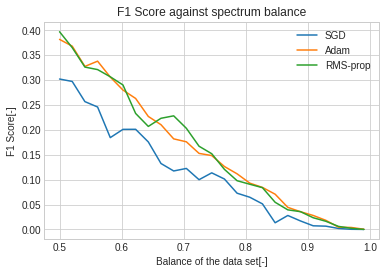

In [16]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_f1, label='SGD')
plt.plot(spects, adam_f1, label='Adam')
plt.plot(spects, rms_prop_f1, label='RMS-prop')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('F1 Score[-]')
plt.title('F1 Score against spectrum balance')
plt.legend(loc='upper right')
plt.savefig('figures/f1-spect.png')

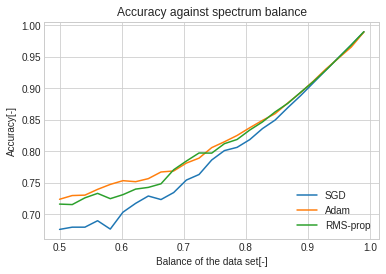

In [17]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_accuracy, label='SGD')
plt.plot(spects, adam_accuracy, label='Adam')
plt.plot(spects, rms_prop_accuracy, label='RMS-prop')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Accuracy[-]')
plt.title('Accuracy against spectrum balance')
plt.legend(loc='lower right')
plt.savefig('figures/accuracy-spect.png')

# Training and test effect

In [18]:
def run_training_benchmarking_f1(data, epochs = 50):
    list_optimzers = ['rms_prop','adam', 'sgd']
    
    
    adam_val_f1 = []
    sgd_val_f1 = []
    rms_val_f1 = []
    
    
    
    one_hot_enc = build_spectrum (data)
    X = one_hot_enc.drop(columns=['y'])
    y = one_hot_enc['y']
    X, y= build_keras (X,y)

    for l in list_optimzers:
        if l=='adam':
            print('[INFO] Using Adam')
            opt = Adam()
            
        elif l == 'rms_prop':
            print('[INFO] Using RMS-prop')
            opt= RMSprop()
        else:
            print('[INFO] Using SGD')
            opt = SGD()
            
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
                
        for train, test in kfold.split(X, y):
            model = build_model('relu')
            model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])
            history = model.fit(X[train], y[train], validation_data=(X[test],y[test]) ,epochs=epochs, batch_size=128, verbose=0)

            if l == 'adam':
                adam_val_f1.append(history.history['val_f1_m'])

            elif l == 'sgd':
                sgd_val_f1.append(history.history['val_f1_m'])
            else:
                rms_val_f1.append(history.history['val_f1_m'])
            
    return sgd_val_f1,adam_val_f1, rms_val_f1
                

In [19]:
def run_training_benchmarking_loss(data, epochs = 50):
    list_optimzers = ['rms_prop','adam', 'sgd']
    
    adam_val_loss = []
    sgd_val_loss = []
    rms_val_loss = []
    
    
    X = build_spectrum (data)
    train, test= train_test_split(X, test_size=0.2, stratify = X['y'], random_state=1)
    x_train, y_train = build_keras (train.drop(columns=['y']),train['y'])
    x_test, y_test = build_keras (test.drop(columns=['y']),test['y'])

    for l in list_optimzers:
        if l=='adam':
            print('[INFO] Using Adam')
            opt = Adam()
            
        elif l == 'rms_prop':
            print('[INFO] Using RMS-prop')
            opt= RMSprop()
        else:
            print('[INFO] Using SGD')
            opt = SGD()
            
        model = build_model(activation='relu')
        model.compile(loss='binary_crossentropy', optimizer=opt)
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=128,
                validation_data=(x_test, y_test), verbose = 0)

        if l == 'adam':
            adam_val_loss = history.history['val_loss']

        elif l == 'sgd':
            sgd_val_loss = history.history['val_loss']
        else:
            rms_val_loss = history.history['val_loss']
            
    return sgd_val_loss, adam_val_loss, rms_val_loss 

# Results

In [ ]:
sgd_val_f1,adam_val_f1, rms_val_f1= run_training_benchmarking_f1(data)

[INFO] Using RMS-prop


In [ ]:
plt.style.use('seaborn-whitegrid')
plt.plot(np.mean(adam_val_f1, axis=0), label='Adam')
plt.plot(np.mean(rms_val_f1, axis=0), label='RMSprop')
plt.plot(np.mean(sgd_val_f1, axis=0), label='SGD')
plt.xlabel('Epochs[-]')
plt.ylabel('F1-Score[-]')
plt.title('Validation F1-Score against epochs')
plt.legend(loc='lower right', frameon = True)
plt.savefig('figures/f1-epochs.png')

In [ ]:
sgd_val_loss, adam_val_loss, rms_val_loss = run_training_benchmarking_loss(data)

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.plot(adam_val_loss, label='Adam')
plt.plot(rms_val_loss, label='RMS-prop')
plt.plot(sgd_val_loss, label='SGD')
plt.xlabel('Epochs[-]')
plt.ylabel('Loss[-]')
plt.title('Validation loss against epochs')
plt.legend(loc='upper right', frameon = True)
plt.savefig('figures/loss-epochs.png')